In [1]:
dataset_path = "/content/dataset" # folder containing pairs of .png/.jpg/.jpeg images and .txt files describing the image
checkpoint_path = "/content/checkpoints" # folder to save/load the checkpoints
output_image_path = "/content/imagen_output.png" # path to save a generated image
checkpoint_rate = 100 # save checkpoint file every x iterations
epochs = 2 #for every unet, ofc

#The real batch size
batch_ss = 12
#Batch size to grad accum when using trainer class, saves from OOM, real batch size should be bigger than this
batch_s =  6
#Use EMA when using trainer class? If use, sampling will result just a noise
use_ema = False
#Which method to use? imagen or trainer class?
meth = "trainer" # "imagen" or "trainer"

In [2]:
# Initialize

import math
import os
import shutil

from imagen_pytorch.t5 import t5_encode_text
import torch, glob
from imagen_pytorch import Unet, Imagen, ImagenTrainer
from tqdm.notebook import tqdm
from datetime import datetime
import torchvision
import torchvision.transforms as T

def get_emb_tensor(files):
    texts = []
    for i in files:
        f = open(i + "txt", "r")
        texts.append(f.read())
        f.close()
    text_embeds, text_masks = t5_encode_text(texts, name = 'google/t5-v1_1-base')
    text_embeds, text_masks = map(lambda t: t.to('cuda:0'), (text_embeds, text_masks))
    return text_embeds, text_masks

image_size = 256

#thanks KyriaAnnwyn
def get_images_tensor(files):
    img_arr = []
    transforms = torch.nn.Sequential(
        T.Resize(image_size),
        T.RandomHorizontalFlip(),
        T.CenterCrop(image_size),
        T.ConvertImageDtype(torch.float)
    )
    exts = ["jpg", "jpeg", "png"]
    for i in files:
        fileName = None
        for ext in exts:
            if os.path.isfile(i + ext):
                fileName = i + ext
                break
        if fileName == None:
            raise ValueError(f"Could not find image for {i}")
        img_arr.append((transforms(torchvision.io.read_image(fileName, torchvision.io.ImageReadMode.RGB)) * 2 - 1).unsqueeze(0))
    img_embeds = torch.cat((img_arr), dim=0).to('cuda')
    return img_embeds
    
current_checkpoint_path = os.path.join(checkpoint_path, "checkpoint.pt")

def saveCheckpoint(trainer: ImagenTrainer):
    print("Saving checkpoint")
    current_datetime = datetime.now().strftime("%Y%m%d-%H%M%S")
    new_checkpoint_path = os.path.join(checkpoint_path, f"checkpoint-{current_datetime}.pt")
    trainer.save(new_checkpoint_path)
    shutil.copyfile(new_checkpoint_path, current_checkpoint_path)

def loadCheckpoint(trainer: ImagenTrainer):
    try:
        trainer.load(current_checkpoint_path)
        print("Loaded checkpoint")
    except: pass

unet1 = Unet(
    dim = 32,
    cond_dim = 512,
    dim_mults = (1, 2, 4, 8),
    num_resnet_blocks = 3,
    layer_attns = (False, True, True, True),
)

unet2 = Unet(
    dim = 32,
    cond_dim = 512,
    dim_mults = (1, 2, 4, 8),
    num_resnet_blocks = (2, 4, 8, 8),
    layer_attns = (False, False, False, True),
    layer_cross_attns = (False, False, False, True)
)

imagen = Imagen(
    unets = (unet1, unet2),
    image_sizes = (64, 256),
    beta_schedules = ('cosine', 'linear'),
    timesteps = 1000,
    cond_drop_prob = 0.5
).cuda()

In [3]:
# Train (this can be skipped if running inference on an existing checkpoint)

trainer = ImagenTrainer(imagen, use_ema = use_ema)

#feed images into imagen, training each unet in the cascade
#try to load last ckpt
loadCheckpoint(trainer)

a = glob.glob(f"{dataset_path}/*.txt")
last_i = 0
batches = []
batch_ss = batch_ss
temp = 0
st = ''
for i, na in enumerate(a):
  if i % batch_ss == 0:
    last_i+=1
  
  st = st + na[:-3] + ' '
  
  
  if temp != last_i:
      if st != '': batches.append(st)
      st = ''
  temp = last_i
if st != '': batches.append(st)
st = batches[0]
batches.pop(0)
if batch_ss!= 1: batches[-1] += st 



for i in (1, 2):
  l_arr = []
  for eps in range(1, epochs+1):
      
      with tqdm(total=len(batches)) as pbar:
          for step, e in enumerate(batches):
              
              batch = batches[step].split(' ')[:-1]
              
              text_embeds, text_masks = get_emb_tensor(batch)
              images = get_images_tensor(batch)



              if meth == 'imagen':
                loss = imagen(images, text_embeds = text_embeds, text_masks = text_masks, unet_number = i)
                loss.backward()
              else:
                loss = trainer(images, text_embeds = text_embeds, text_masks = text_masks, unet_number = i, max_batch_size = batch_s)
                trainer.update(unet_number = i)
              l_arr.append(loss)
              if step % checkpoint_rate == 0 and step !=0 and not math.isnan(loss):
                  saveCheckpoint(trainer)
              pbar.set_description(f'Unet Num: {i}  Epoch: {eps}  Loss: {loss} Avg Loss: {round((sum(l_arr)/len(l_arr)), 3)}')
              pbar.update()
      if not math.isnan(loss): saveCheckpoint(trainer)



loading saved imagen at version 0.0.60, but current package version is 0.0.60
Loaded checkpoint


  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at google/t5-v1_1-base were not used when initializing T5EncoderModel: ['decoder.block.11.layer.2.DenseReluDense.wi_0.weight', 'decoder.block.6.layer.2.DenseReluDense.wo.weight', 'decoder.block.5.layer.2.DenseReluDense.wo.weight', 'decoder.block.7.layer.1.EncDecAttention.k.weight', 'decoder.block.0.layer.0.SelfAttention.k.weight', 'decoder.block.7.layer.2.DenseReluDense.wi_0.weight', 'decoder.block.6.layer.2.layer_norm.weight', 'decoder.block.2.layer.2.DenseReluDense.wi_1.weight', 'decoder.block.1.layer.0.SelfAttention.k.weight', 'decoder.block.1.layer.1.EncDecAttention.o.weight', 'decoder.block.8.layer.1.EncDecAttention.o.weight', 'decoder.block.0.layer.0.layer_norm.weight', 'decoder.block.6.layer.0.SelfAttention.k.weight', 'decoder.block.10.layer.1.EncDecAttention.q.weight', 'decoder.block.8.layer.0.SelfAttention.o.weight', 'decoder.block.2.layer.1.EncDecAttention.v.weight', 'decoder.block.6.layer.0.layer_norm.weight', 'decoder.block.4.layer.2.Den

Saving checkpoint


  0%|          | 0/5 [00:00<?, ?it/s]

Saving checkpoint


  0%|          | 0/5 [00:00<?, ?it/s]

Saving checkpoint


  0%|          | 0/5 [00:00<?, ?it/s]

Saving checkpoint


loading saved imagen at version 0.0.60, but current package version is 0.0.60
Loaded checkpoint
['Danger High Voltage Label']


sampling loop time step: 100%|██████████| 100/100 [00:13<00:00,  7.58it/s]
2it [00:19,  9.92s/it]

torch.Size([1, 3, 256, 256])
torch.Size([3, 256, 256])


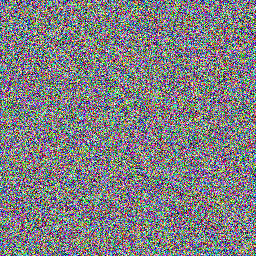

In [6]:
# Run inference

import torch
import torchvision
import torchvision.transforms as T
from PIL import Image

text = "Danger High Voltage Label" # Danger High Voltage Label is 000000012.txt from included dataset
#Timesteps for sample
timesteps =  100

imagen = Imagen(
    unets = (unet1, unet2),
    image_sizes = (64, 256),
    beta_schedules = ('cosine', 'linear'),
    timesteps = timesteps,
    cond_drop_prob = 0.5
).cuda()

trainer = ImagenTrainer(imagen, use_ema = use_ema)
loadCheckpoint(trainer)

# now you can sample an image based on the text embeddings from the cascading ddpm
#texts = [
#    'a puppy looking anxiously at a giant donut on the table',
#    'the milky way galaxy in the style of monet']

texts = [text]
print(texts)
img = trainer.sample(texts, cond_scale = 2.)

# Show the generated image

print(img.shape)
print(img[0].shape)
image = T.ToPILImage()(img[0]).convert("RGB")
image.show() #returns None but expected just display image

import matplotlib.pyplot as plt
plt.imshow(image) #returns image with plt


In [5]:
# Save the image if you like it

from torchvision.utils import save_image
image = img[0]  
save_image(image, output_image_path)